# Developing an AI application

In [58]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import json

import numpy as np
import PIL
from PIL import Image

# Use GPU if it's available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the data
 

In [59]:
def transform_images(data_dir):
    train_dir = data_dir + '/train'
    valid_dir = data_dir + '/valid'
    test_dir = data_dir + '/test'

    # TODO: Define your transforms for the training, validation, and testing sets
    train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                           transforms.RandomResizedCrop(224),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor(),
                                           transforms.Normalize([0.485, 0.456, 0.406],
                                                                [0.229, 0.224, 0.225])])

    test_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

    valid_transforms = transforms.Compose([transforms.Resize(255),
                                          transforms.CenterCrop(224),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])


    # TODO: Load the datasets with ImageFolder
    train_data = datasets.ImageFolder(train_dir,transform=train_transforms)
    test_data = datasets.ImageFolder(test_dir,transform=test_transforms)
    valid_data = datasets.ImageFolder(valid_dir,transform=valid_transforms)

    # TODO: Using the image datasets and the trainforms, define the dataloaders
    trainloader = torch.utils.data.DataLoader(train_data,batch_size=64,shuffle=True) 
    testloader = torch.utils.data.DataLoader(test_data,batch_size=64,shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_data,batch_size=64,shuffle=True)
    
    return train_data,test_data, valid_data, trainloader, testloader, validloader

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [60]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

In [61]:
def network_model(structure='vgg13',dropout=0.5, hidden_layer1 = 4096,learning_rate = 0.0001):
    # TODO: Build and train your network
    if structure =='vgg13':
        model = models.vgg13(pretrained=True)
    elif structure =='vgg16':
        model = models.vgg16(pretrained=True)
    else:
        print("Please try for vgg13 or vgg16 only")

    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(nn.Linear(25088, hidden_layer1),
                                     nn.ReLU(),
                                     nn.Dropout(dropout),
                                     nn.Linear(hidden_layer1, 102),
                                     nn.LogSoftmax(dim=1))
    criterion = nn.NLLLoss()
    
    optimizer = optim.Adam(model.classifier.parameters(),lr=learning_rate)
    model.to(device)
    
    return model, criterion, optimizer

In [62]:
def deep_learning(model, criterion, optimizer, epochs=2, print_every = 5, trainloader=0, validloader=0):
    
    steps = 0
    running_loss = 0

    for epoch in range(epochs):
        for inputs, labels in trainloader:
            steps +=1

            inputs, labels = inputs.to(device), labels.to(device)

            logps = model.forward(inputs)
            loss = criterion(logps, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if steps % print_every == 0:
                test_loss = 0
                accuracy = 0
                model.eval()
                with torch.no_grad():
                    for inputs, labels in validloader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        logps = model.forward(inputs)
                        batch_loss = criterion(logps, labels)

                        test_loss += batch_loss.item()

                        ps = torch.exp(logps)
                        top_p, top_class = ps.topk(1, dim=1)
                        equals = top_class == labels.view(*top_class.shape)
                        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

                print(f"Epoch {epoch+1}/{epochs}.. "
                      f"Train loss: {running_loss/print_every:.3f}.. "
                      f"Test loss: {test_loss/len(validloader):.3f}.. "
                      f"Test accuracy: {accuracy/len(validloader):.3f}")
                running_loss = 0
                model.train()     

In [63]:
model, criterion, optimizer = network_model()
train_data,test_data, valid_data, trainloader, testloader, validloader = transform_images('flowers')
deep_learning(trainloader=trainloader, validloader=validloader, model=model,criterion=criterion, optimizer=optimizer)

Epoch 1/2.. Train loss: 4.604.. Test loss: 4.257.. Test accuracy: 0.119
Epoch 1/2.. Train loss: 4.238.. Test loss: 3.892.. Test accuracy: 0.188
Epoch 1/2.. Train loss: 3.869.. Test loss: 3.422.. Test accuracy: 0.286
Epoch 1/2.. Train loss: 3.607.. Test loss: 3.087.. Test accuracy: 0.388
Epoch 1/2.. Train loss: 3.405.. Test loss: 2.729.. Test accuracy: 0.446
Epoch 1/2.. Train loss: 3.196.. Test loss: 2.393.. Test accuracy: 0.525
Epoch 1/2.. Train loss: 2.802.. Test loss: 2.149.. Test accuracy: 0.567
Epoch 1/2.. Train loss: 2.727.. Test loss: 1.923.. Test accuracy: 0.606
Epoch 1/2.. Train loss: 2.464.. Test loss: 1.707.. Test accuracy: 0.622
Epoch 1/2.. Train loss: 2.355.. Test loss: 1.543.. Test accuracy: 0.649
Epoch 1/2.. Train loss: 2.270.. Test loss: 1.367.. Test accuracy: 0.687
Epoch 1/2.. Train loss: 2.004.. Test loss: 1.292.. Test accuracy: 0.692
Epoch 1/2.. Train loss: 1.962.. Test loss: 1.181.. Test accuracy: 0.733
Epoch 1/2.. Train loss: 1.752.. Test loss: 1.084.. Test accuracy

## Testing your network

In [64]:
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print(f"Test loss: {test_loss/len(testloader):.3f}.. "
      f"Test accuracy: {accuracy/len(testloader):.3f}")      

Test loss: 0.518.. Test accuracy: 0.858


## Save the checkpoint

In [65]:
# TODO: Save the checkpoint
def save_checkpoint(model=0,path='checkpoint.pth',structure ='vgg13', hidden_layer1 = 4096,dropout=0.5,learning_rate=0.0001,epochs=2):

    checkpoint = {'structure' :structure,
                  'hidden_layer1':hidden_layer1,
                  'dropout':dropout,
                  'epochs':epochs,
                  'state_dict': model.state_dict(),
                  'classifier': model.classifier,
                  'learning_rate': learning_rate,
                  'class_to_idx': train_data.class_to_idx,
                  'optimizer_dict': optimizer.state_dict()}
    torch.save(checkpoint, path)
    
save_checkpoint(model=model)

## Loading the checkpoint

In [66]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    structure = checkpoint['structure']
    dropout = checkpoint['dropout']
    hidden_layer1 = checkpoint['hidden_layer1']
    learning_rate = checkpoint['learning_rate']
    model, criterion, optimizer = network_model(structure,dropout,hidden_layer1,learning_rate)
    for param in model.parameters():
        param.requires_grad = False
    model.classifier = checkpoint['classifier']
    model.class_to_idx = checkpoint['class_to_idx']
    model.load_state_dict(checkpoint['state_dict'])
    return optimizer,criterion, model

optimizer,criterion, model = load_checkpoint('checkpoint.pth')

# Inference for classification


## Image Preprocessing

In [67]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    
    pil_image = PIL.Image.open(image)
    transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
    
    np_image = transform(pil_image)
        
    return np_image

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [68]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

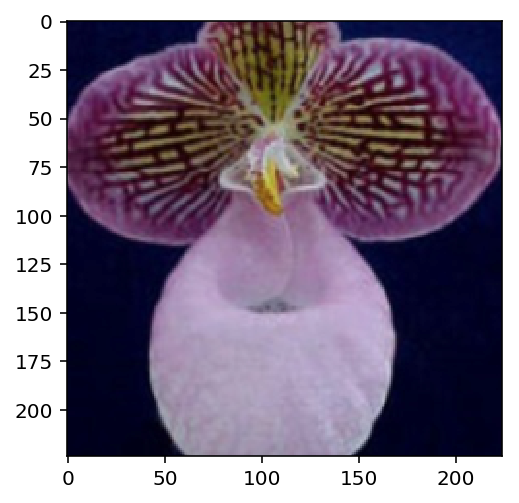

In [44]:
#test above
image = 'sample_img.jpg'
imshow(process_image(image),None,'blanket flower')

## Class Prediction

In [69]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    # TODO: Implement the code to predict the class from an image file

    load_checkpoint('checkpoint.pth')
    
    model.idx_to_class = dict(map(reversed, model.class_to_idx.items()))
    
    with torch.no_grad():
        image = process_image(image_path).unsqueeze(dim=0)
        image = image.float()
        outputs = model.forward(image.cuda())
        ps = torch.exp(outputs)
        probs, indices = ps.topk(topk)
        #probs = probs.squeeze()
        classes = [model.idx_to_class[idx] for idx in indices[0].tolist()]
        
    return probs, classes

In [56]:
#test above
probs, classes = predict('sample_img.jpg', model)
print(probs)
print(classes)

tensor(1.00000e-02 *
       [[ 2.0571,  1.8384,  1.7421,  1.6613,  1.6433]], device='cuda:0')
['52', '78', '98', '57', '45']


## Sanity Checking

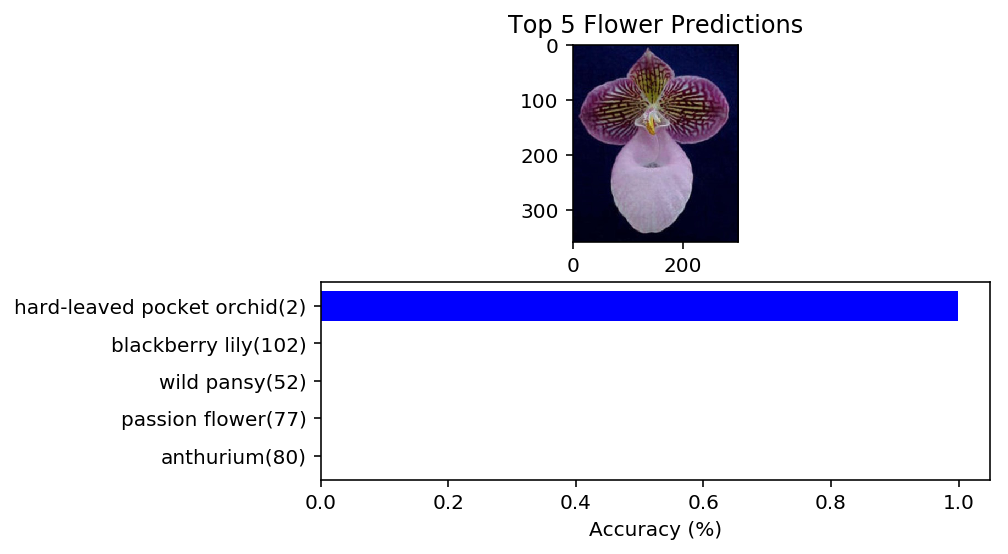

In [70]:
def display_prediction(image_path,model):
    probs, classes = predict(image_path,model)
    flower_classes = [cat_to_name[str(cls)] + "({})".format(str(cls)) for cls in classes]
    im = Image.open(image_path)
    fig, ax = plt.subplots(2,1)
    ax[0].imshow(im);
    y_positions = np.arange(len(flower_classes))
    ax[1].barh(y_positions,probs[0],color='blue')
    ax[1].set_yticks(y_positions)
    ax[1].set_yticklabels(flower_classes)
    ax[1].invert_yaxis()  # labels read top-to-bottom
    ax[1].set_xlabel('Accuracy (%)')
    ax[0].set_title('Top 5 Flower Predictions')
    return None

display_prediction('sample_img.jpg',model)